# Longitude, Latitude, Tilt and Azimuth Estimation Example

_Bennet Meyers, Alejandro Londono_

06/29/2021, updated 8/2/2022

This notebook demonstrates the usage of the `ConfigurationEstimator` class to estimate latitude, longitude, tilt and azimuth from field data. NIST provides data from a collection of fully instrumented and documented arrays installed at their Maryland campus. These arrays have known latitude, longitude, tilt, and azimuth parameters. The data is publicly available [here](https://doi.org/10.18434/M3S67G), and documentation of the systems is provided [here](http://dx.doi.org/10.6028/NIST.TN.1896). In preparation for this work, I downloaded the available data, which is provided in daily CSV files cover a time span of 4 years, separated by system (ground, canopy, roof, and the two meteorological stations). I extracted the power and irradiance columns from these 6937 individual CSV files, and combined them to generate a single table spanning four years. The resulting `pickle` file is about 1.4GB in size, and is available from [my personal OneDrive](https://office365stanford-my.sharepoint.com/:u:/g/personal/bennetm_stanford_edu/EUVw7RDf-LFDi-E5g-m3qk8B51sy3zYW5ts0obsUpUO6Gw?e=rOsZuQ).

To run this notebook, download the `pickle` file, and place it in the same directory as this notebook.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Standard Imports
import pandas as pd
from glob import glob
from time import time
# Solar Data Tools imports
from solardatatools import DataHandler
# pv-system-profiler imports
from pvsystemprofiler.estimator import ConfigurationEstimator

In [3]:
# Extra import: This notebook uses the geopy package to calculate the error in lat/long
# estimation. This package is not a requirement for the the software and isn't installed as a dependency.
# 
try:
    from geopy.distance import great_circle
except ModuleNotFoundError:
    print("No worries, we'll just skip that part below...")

# Configuration information from the published documentation:

In [4]:
ground_system_configuration = {
    'longitude': -77.2141,
    'latitude': 39.1319,
    'tilt': 20,
    'azimuth': 0,
}

# Load in 4-year data file, derived from NIST CSV files.

In [5]:
try:
    df = pd.read_pickle('NIST_all_power_and_irradiance.pkl')
except FileNotFoundError:
    print('Please download example data file to working directory')

# Utilize standard `solar-data-tools` preprocessing pipeline.

## Using AC power signal

total time: 17.77 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              11.20s
Cleaning                   0.51s
Filtering/Summarizing      6.05s
    Data quality           0.39s
    Clear day detect       0.23s
    Clipping detect        4.37s
    Capacity change detect 1.06s

Length:                4.00 years
Capacity estimate:     30.13 kW
Data sampling:         1.0 minute
Data quality score:    92.1%
Data clearness score:  15.7%
Inverter clipping:     False
Time shifts corrected: None
Time zone correction:  None


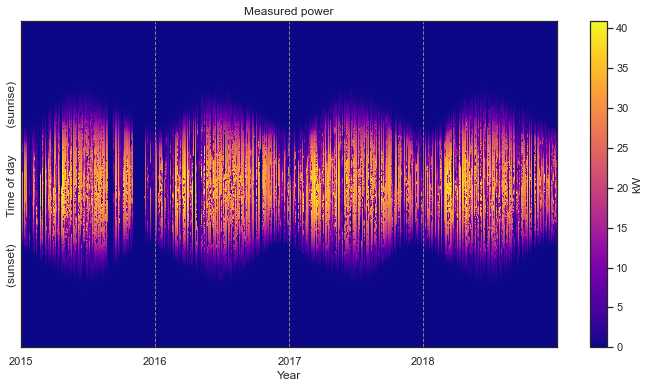

In [6]:
dh_ac_power = DataHandler(df)
dh_ac_power.run_pipeline(power_col=('ground', 'ShuntPDC_kW_Avg_4'))
dh_ac_power.report()
dh_ac_power.plot_heatmap(matrix='filled');

# Initialize estimator class with the data handler instance and timezone information.

In [7]:
est_power = ConfigurationEstimator(dh_ac_power, gmt_offset=-5)

# Estimate longitude using default keyboard arguments:

## Using AC power signal

In [15]:
est = est_power
est.estimate_longitude()
out = pd.DataFrame(index=['real longitude', 'estimated longitude', 'error'],
                  data=[ground_system_configuration['longitude'],
                        est.longitude,
                        ground_system_configuration['longitude'] - est.longitude],
                  columns=[''])
out

,
real longitude,-77.214100
estimated longitude,-78.360455
error,1.146355


# Estimate longitude using Haghdadi's published method of taking the median of daily estimates:

In [17]:
est = est_power
est.estimate_longitude(estimator='calculated', eot_calculation=('da_rosa'),)
out = pd.DataFrame(index=['real longitude', 'estimated longitude', 'error'],
                  data=[ground_system_configuration['longitude'],
                        est.longitude,
                        ground_system_configuration['longitude'] - est.longitude],
                  columns=[''])
out

,
real longitude,-77.2141
estimated longitude,-78.3763
error,1.1622


# Estimate longitude using cost-function minimization method, with a Huber cost.

In [18]:
est = est_power
est.estimate_longitude(estimator='fit_huber')
out = pd.DataFrame(index=['real longitude', 'estimated longitude', 'error'],
                  data=[ground_system_configuration['longitude'],
                        est.longitude,
                        ground_system_configuration['longitude'] - est.longitude],
                  columns=[''])
out

,
real longitude,-77.214100
estimated longitude,-78.472109
error,1.258009


# Estimate latitude using default keyboard arguments

## Using AC power signal

In [19]:
est = est_power
est.estimate_latitude()
out = pd.DataFrame(index=['real latitude', 'estimated latitude', 'error'],
                  data=[ground_system_configuration['latitude'],
                        est.latitude,
                        ground_system_configuration['latitude'] - est.latitude],
                  columns=[''])
out

,
real latitude,39.131900
estimated latitude,49.589027
error,-10.457127


# Estimate error in miles for Longitude and Latitude Calculation

In [20]:
est = est_power
est.estimate_longitude()
est.estimate_latitude()

lon = est.longitude
lat = est.latitude
ground_coord = (ground_system_configuration['latitude'], ground_system_configuration['longitude'])
estimated_coord = (lat, lon)
try:
    error_dist = great_circle(estimated_coord, ground_coord).miles
except NameError:
    error_dist = np.nan
out = pd.DataFrame(index=['lon err (deg)', 'lat err (deg)', 'error (miles)'],
                  data=[ground_system_configuration['longitude'] - est.longitude,
                        ground_system_configuration['latitude'] - est.latitude,
                        error_dist],
                  columns=[''])
out

,
lon err (deg),1.146355
lat err (deg),-10.457127
error (miles),724.710631


# Estimate tilt and azimuth with known values of longitude and latitude 

## Using the AC power signal

In [25]:
est = est_power
est.estimate_orientation(longitude=ground_system_configuration['longitude'], 
                         latitude=ground_system_configuration['latitude'])
out = pd.DataFrame(index=['real', 'estimated', 'error'],
                  data={'tilt': [ground_system_configuration['tilt'], est.tilt, 
                                 ground_system_configuration['tilt'] - est.tilt],
                        'azimuth': [ground_system_configuration['azimuth'], est.azimuth,
                                    ground_system_configuration['azimuth'] - est.azimuth]})
out

,tilt,azimuth
real,20.000000,0.000000
estimated,34.086296,-0.300752
error,-14.086296,0.300752


# Estimate all location and orientation parameters

## Using AC power signal

In [27]:
est = est_power
est.estimate_all()
out = pd.DataFrame(index=['real', 'estimated', 'error'],
                  data={'lon': [ground_system_configuration['longitude'], est.longitude,
                                ground_system_configuration['longitude'] - est.longitude],
                        'lat': [ground_system_configuration['latitude'], est.latitude,
                                ground_system_configuration['latitude'] - est.latitude],
                        'tilt': [ground_system_configuration['tilt'], est.tilt, 
                                 ground_system_configuration['tilt'] - est.tilt],
                        'azimuth': [ground_system_configuration['azimuth'], est.azimuth,
                                    ground_system_configuration['azimuth'] - est.azimuth]})
out

,lon,lat,tilt,azimuth
real,-77.214100,39.131900,20.000000,0.000000
estimated,-78.360455,49.589027,44.848629,-3.739641
error,1.146355,-10.457127,-24.848629,3.739641
